# Admin Panel

https://socket.io/blog/admin-ui-first-release/

- room과 모든 클라이언트 확인 가능

# 01 Admin Panel UI install

https://socket.io/docs/v4/admin-ui/

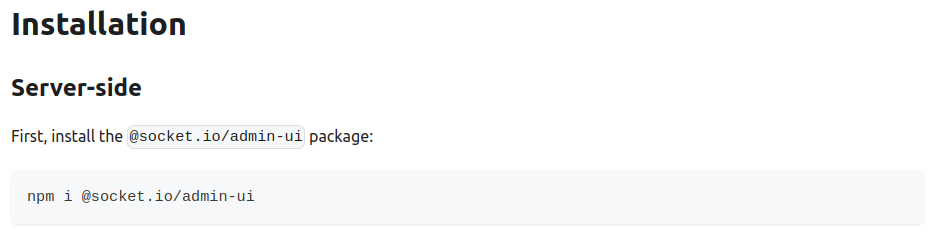

```shell
yarn add @socket.io/admin-ui
```

#### 접속
https://admin.socket.io/

###### server.js 수정
```javascript
import express from "express";
import http from "http";
import { Server } from "socket.io";
import { instrument } from "@socket.io/admin-ui";

const app = express();
const port = 3000;

// json file 입출력 설정
app.use(express.json());

// pug 설정
app.set("view engine", "pug");
app.set("views", __dirname + "/views");

// static 작업
app.use("/public", express.static(__dirname + "/public"));

// route 설정
app.get("/", (_, res) => res.render("home"));
app.get("/*", (_, res) => res.redirect("/"));

// http server
const httpServer = http.createServer(app);

// io server
const wsServer = new Server(httpServer, {
  cors: {
    origin: ["https://admin.socket.io"],
    credentials: true,
  },
});

instrument(wsServer, {
  auth: false,
});

function publicRooms() {
  const {
    sockets: {
      adapter: { sids, rooms },
    },
  } = wsServer;

  const publicRooms = [];
  rooms.forEach((_, key) => {
    if (sids.get(key) === undefined) {
      publicRooms.push(key);
    }
  });
  // sids에는 개인방, rooms에는 개인방,공개방 다있음
  // rooms가 sids를 포함한다 보면됨
  // 공개방만 얻고 싶을때는 rooms에서 sids를 빼면 됨
  return publicRooms;
}

function countRoom(roomName) {
  return wsServer.sockets.adapter.rooms.get(roomName)?.size;
}

wsServer.on("connection", (socket) => {
  socket["nickname"] = "Anon";
  socket.onAny((event) => {
    // console.log(wsServer.sockets.adapter);
    console.log(`Socket Event: ${event}`);
  });

  socket.on("enter_room", (roomName, done) => {
    socket.join(roomName);
    done();
    // room 전체에 메시지 보내기
    socket.to(roomName).emit("welcome", socket.nickname, countRoom(roomName));

    // message를 모두에게 보냄
    wsServer.sockets.emit("room_change", publicRooms());
  });

  socket.on("disconnecting", () => {
    socket.rooms.forEach((room) =>
      socket.to(room).emit("bye", socket.nickname, countRoom(room) - 1)
    );
  });

  socket.on("disconnect", () => {
    wsServer.sockets.emit("room_change", publicRooms());
  });

  socket.on("message", (msg, room, done) => {
    socket.to(room).emit("message", `${socket.nickname} : ${msg}`);
    done();
  });

  socket.on("nickname", (nickname) => (socket["nickname"] = nickname));
});

httpServer.listen(port, () => {
  console.log(`Joom app listening on http://localhost:${port}`);
});

```